## Classification - Data Science Portfolio - Maximilian Koch

**Dataset**: Astronomical objects<br>
**Target variable**: Predicting the type of astronomical objects<br>
**Features**: Light spectra, movement<br>
**Techniques applied**: Multiple-class SVM implementation from scratch, voting ensemble from scratch<br>



SVMs are ...

In this notebook, I will:
* Implement a binary class SVM from scratch
* Implement a multiple class on-versus-rest SVM from scratch
* Implement a voting ensemble from scratch

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

The dataset is for classification of astronomical objects into three categories: galaxies, stars and quasars. There is a class imbalance (galaxies are about 50%), thus f1 macro is used as an evaluation metric.
Most variables contain information about the light spectra of the objects.

In [4]:
#storing this for later
orig_class = df['class'].copy()
df = df.drop(['class','obj_ID','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID'],axis=1)

In [5]:
from sklearn.preprocessing import StandardScaler
#data should be scaled for SVMs. class must not be scaled.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df['class'] = orig_class
scaled_df = scaled_df[:10000] #less training time

X = scaled_df.drop('class',axis=1)
y = scaled_df['class']

### Two-class SVM

Since the dataset has three classes, I created a classification problem with two labels: star or not star.

In [6]:
from sklearn.metrics import f1_score

def train_base_svm(X, y, learning_rate=0.001, n_iterations=1000):
    #get np arrays
    X = X.values
    #y is already a numpy array when using OVR as below
    n_samples, n_features = X.shape
    #one weight per feature
    w = np.zeros(n_features)
    #bias
    b = 0
    for i in range(n_iterations):
        #for each sample
        for idx, x_i in enumerate(X):
            y_i = y[idx] #label for sample
            if y_i * (np.dot(x_i, w) + b) < 1:
                #gradient descent
                w = w + learning_rate * (y_i * x_i)
                b = b + learning_rate * y_i
    return w, b

def predict_base_svm(X, w, b):
    X = X.values
    predictions = np.dot(X, weights) + bias
    return np.sign(predictions).astype(np.int8)

#turning the current three classes into two classes
binary_df = scaled_df.copy()
#star or not star. -1/1 encoding works easiest with SVM. sgn can just be applied
binary_df['class'] = binary_df['class'].replace({'GALAXY':-1,'STAR':1,'QSO':-1})
binary_train, binary_test = binary_df[:8000], binary_df[8000:] #80/20 split

#train the SVM:
weights, bias = train_base_svm(binary_train.drop('class',axis=1),binary_train['class'].values)
#Training set prediction:
predictions_train = predict_base_svm(binary_train.drop('class',axis=1),weights,bias)
#Test set prediction:
predictions_test = predict_base_svm(binary_test.drop('class',axis=1),weights,bias)

print('train data f1:',f1_score(binary_train['class'].values,predictions_train,average='macro'))
print('test data f1:',f1_score(binary_test['class'].values,predictions_test,average='macro'))

C:\Users\mk090\AppData\Local\Temp\ipykernel_12028\2588840994.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  binary_df['class'] = binary_df['class'].replace({'GALAXY':-1,'STAR':1,'QSO':-1})


train data f1: 0.9796163875576239
test data f1: 0.9739223807332413


The two-class linear SVM already performs extremely well. The f1 score is very high and performs almost equally well on the train and test data.
Thus there are no indications of overfitting.

### Multi-class OVR SVM

To use the original 3 class dataset, I implemented a multi-class SVM using a One vs Rest approach, because it is the easiest to implement and intuitive.

In [7]:
def train_svm(X, y, learning_rate=0.01, n_iterations=1000, logging=True):
    unique_classes = y.unique()
    classifiers = {}

    for cls in unique_classes:
        if logging:
            print('training',cls,'vs. others...')
        # Create binary labels: 1 for the current class, -1 for all others
        binary_y = np.where(y == cls, 1, -1)
        weights, bias = train_base_svm(X, binary_y, learning_rate, n_iterations)
        classifiers[cls] = (weights, bias)

    return classifiers

def predict_svm(X, ovr_classifiers):
    X_values = X.values
    num_samples = X_values.shape[0]
    num_classifiers = len(ovr_classifiers)
    predictions = np.zeros((num_samples, num_classifiers))
    class_labels = list(ovr_classifiers.keys())

    for i, cls in enumerate(class_labels):
        weights, bias = ovr_classifiers[cls]
        # Get the raw scores from the decision function for each OVR classifier
        predictions[:, i] = np.dot(X_values, weights) + bias

    #for direct evaluation. translating back into classes
    predicted_classes = np.array([class_labels[np.argmax(sample_predictions)] for sample_predictions in predictions])
    return predicted_classes


multi_train, multi_test = scaled_df[:8000], scaled_df[8000:]
classifiers = train_svm(multi_train.drop('class',axis=1),multi_train['class'])
train_predictions = predict_svm(multi_train.drop('class',axis=1),classifiers)
test_predictions = predict_svm(multi_test.drop('class',axis=1),classifiers)

print('Train f1:',f1_score(multi_train['class'].values, train_predictions, average='macro'))
print('Test f1:',f1_score(multi_test['class'].values, test_predictions, average='macro'))

training GALAXY vs. others...
training QSO vs. others...
training STAR vs. others...
Train f1: 0.9016010848224502
Test f1: 0.8866385088489878


The performance decreased, but it still very high. The test f1 is only minimally lower than the train f1, so also no signs of overfitting.

### Voting Ensemble Multi-Class SVM

I wanted to see whether a voting ensemble would even increase the performance further, as that was also already included in the Trees notebook.
(and voting is much easier to implement from scratch than other ensemble techniques)

In [8]:
from collections import Counter

def voting_ensemble_train_svm(X, y, n_estimators=3, learning_rate=0.001, n_iterations=1000):
    ensemble_models = []
    n_samples = X.shape[0]

    chunk_size = n_samples // n_estimators
    start_index = 0

    for i in range(n_estimators):
        end_index = start_index + chunk_size
        X_subset = X.iloc[start_index:end_index]
        y_subset = y.iloc[start_index:end_index]

        print('Training ensemble',i)
        ovr_classifier = train_svm(X_subset, y_subset, learning_rate, n_iterations)
        ensemble_models.append(ovr_classifier)
        start_index = end_index

    return ensemble_models

def voting_ensemble_predict_svm(X, ensemble_models):
    num_samples = X.shape[0]
    predicted_classes = []
    all_predictions = []

    for model in ensemble_models:
        predictions = predict_svm(X, model) 
        all_predictions.append(predictions)

    #count class with most votes. in case of tie first class in the predictions is taken.
    for i in range(num_samples):
        votes = [preds[i] for preds in all_predictions]
        predicted_class = Counter(votes).most_common()[0][0]
        predicted_classes.append(predicted_class)

    return np.array(predicted_classes)

In [9]:

multi_train, multi_test = scaled_df[:8000], scaled_df[8000:]
X_train_multi = multi_train.drop('class', axis=1)
y_train_multi = multi_train['class']
X_test_multi = multi_test.drop('class', axis=1)
y_test_multi = multi_test['class']

n_estimators = 3
ensemble_models = voting_ensemble_train_svm(X_train_multi.copy(), y_train_multi.copy(), n_estimators=n_estimators, learning_rate=0.1, n_iterations=1000)
ensemble_train_predictions = voting_ensemble_predict_svm(X_train_multi, ensemble_models)
ensemble_test_predictions = voting_ensemble_predict_svm(X_test_multi, ensemble_models)

print("Voting Ensemble OVR SVM Results:")
print("Train F1 Score (macro):", f1_score(y_train_multi.values, ensemble_train_predictions, average='macro'))
print("Test F1 Score (macro):", f1_score(y_test_multi.values, ensemble_test_predictions, average='macro'))


Training ensemble 0
training GALAXY vs. others...
training QSO vs. others...
training STAR vs. others...
Training ensemble 1
training GALAXY vs. others...
training STAR vs. others...
training QSO vs. others...
Training ensemble 2
training QSO vs. others...
training STAR vs. others...
training GALAXY vs. others...
Voting Ensemble OVR SVM Results:
Train F1 Score (macro): 0.9232385699256386
Test F1 Score (macro): 0.9025906269184637


There is a slight increase in performance.
Given that only a linear kernel is used, the performance is great.
The remaining misclassifications could probably be fixed by access to more variables and a non-linear kernel.

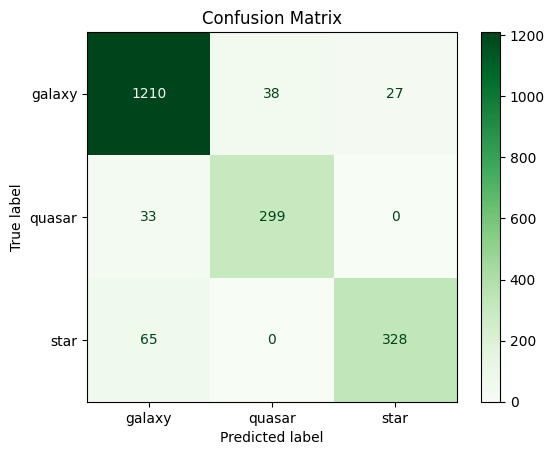

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_multi, ensemble_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['galaxy','quasar','star']) #checked label order with value counts
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

All classes get identified quite accuractely. There are some confusions between galaxies and quasars and a few between stars and galaxies.
Interestingly, there are no confusions between quasars and stars.
Stars have more narrow, specific light spectra, unlike quasars that have very broad spectra and are much more luminous. That explains the clear decision boundary between these two classes.